# Project 2

## Imports

In [1]:
%matplotlib inline
from IPython.display import Image
from IPython.core.display import display

## Historical data

### Structures in the data

#### Overview of the data

We could look at the simple distribution of the two symptoms. This shows the frequency of the two symptoms in the entire dataset. From the histogram it could seem like symptom 2 is less frequent than symptom 1.

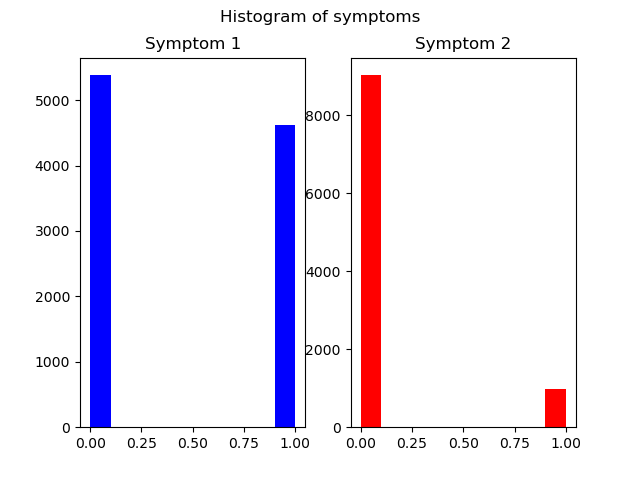

In [2]:
display(Image(filename="img/freq_hist.png", width = 600))

#### Single cause versus multiple cause model

Just by looking at the simple histogram of frequencies we see that the distribution of the two symptoms are very different. Symptom 2 seems to be far less frequent than symptom 1. In order to look further into into unknown clusters in the data, we could use unsupervised learning techniques such as K-means clustering or hierarchical clustering. Our overall goal is to predict the symptoms based on the covariates which are gender, smoker and gene expression data. Because of the number of covariates (the number of different gene expressions), it is not trivial to examine if there is a single cause (covariate) for the symptoms or not.

There could also be a subset of gene expression that are the main cause of the symptoms, but determining which of the gene expression that explains the most of the variability in the symptoms could be more difficult to infer. This is closely related to the concept of confounding covariates. Two covariates, if correlated, could be subject to confounding in such a way that the effect of the second covariate could be partly expressed through the first covariate. In the case of two covariates, the second is then affecting through $\hat{\rho} \sqrt{\frac{\sigma_{1}}{\sigma_{2}}}$ where $\hat{\rho}$ is the correlation between the covariates, $\sigma_i$ is the standard deviation of the covariate $i$ (Borgan, 2019, p. 1). In our case this could be the case if we include some number of genes as covariates. Some genes could be confounded by other genes, masking their influence on the response variable.

By attempting to narrow down the covariates that cause a particular symptom, we are looking at a "causes of effect" problem (Dawid, 2015, p. 5). That is, what covariates causes the symptoms observed in the data set. When it comes to data sets that we observe after the "experiment" has taken place (that is, collecting the data) there should ideally be exchangeability among the observations (Dawid, 2015, p. 21). This condition may be difficult to verify when looking at the dataset, especially when taking into account the uncertainty that (may) be involved when registering data for the symptoms. These could range from objective measurese such as a level of concentration or to more subjective measures such as an individual assessment of symptoms.

Further, Dawid also discusses the negative impact of confounding when observing the data. In order to achieve this, there must in principal be exchangeability between groups within the data. He then considers the case of having the treated groups being exchangeable with the non-treated group in order to have exchangeability and that this in theory happens when the observations are randomised (Dawid, 2015, pp. 21-22). Dawid then relates the absence of confounding to independence between the covariates (Dawid, 2015, p. 22). This can also be considered when looking at the definition from Borgan above, where confounding is expressed through correlation $\hat{\rho}$ between the covariates.

##### K-means clustering

The idea behind K-means clustering is to find the clusters that minimize the variation within each of the clusters. The distance between two observations could then be measured as the squared euclidean distance between the $C$ covariates of the two observations

$$
\sum_{j=1}^{C} (x_{ij} - x_{i'j})^{2}
$$

adapted from (James et al., 2013, p. 387). Further, we then want to minimize the following equation in order to obtain the "optimal" clusters where $G_{k}$ is one of the $K$ clusters and we sum the squared euclidean distance between points within the same cluster $G_{k}$

$$
\sum_{k=1}^{K} \frac{1}{|G_{k}|} \sum_{i \cap i' \in G_{k}} \sum_{j=1}^{C} (x_{ij} - x_{i'j})^{2}
$$

adapted from (James et al., 2013, p. 387).

The algorithm then computes the "mean" observation for each cluster which in fact is the mean of all the covariates within the cluster. Then the observations are placed in the clusters in which they are closest to measured in for example squared euclidean distance (James et al., 2013, p. 388).

In this example, we could use this algorithm with $K=2$ and check the clusters created by the algorithm with the different symptoms. Intuitively, if a large percentage of the cluster 1 observations exhibit one of the symptoms compared to those observations in cluster 2 it could be reason to investigate closer if there in fact are two different clusters of observations, each mainly related to each of the symptoms. Unfortunately, the K-means clustering will be difficult to perform due to the binary structure of the data.


##### Logistic regression

I will instead look into logistic regression as a model for the data. There could be defined a model for each of the covariates and all combinations of covariates up to the full model with all the covariates. First, I want to try using cross-validation on a valdiation set (within the training data) in order to select the covariates that make up the "best" model when it comes to prediction. In that way, I could say that it is more likely that there is a single-cause model if the best model w.r.t. prediction is a model with a single covariate. On the other hand, if the number of "optimally" chosen covariates are $>1$ then this could imply that there is in fact a multiple-cause model that is more likely. It would also have been possible to use different forms of information criterias in order to perform variable selection, such as AIC or BIC. This would have penalized the number of covariates directly to avoid overfitting. An alternative to this is cross-validation on the training data where the cross-validation error is the misclassification rate. This is then measured on the validation set as described below.

In order to check the effect of the different covariates, I used recursive feature elimination with cross-validation in order to select the covariates based on the misclassification score (scikit learn, 2020). This is then specified to use a stratified K-fold cross-validation (because of the few occurences of symptom 2). What is interesting is the fact that for both symptoms, the variable selection selects one covariate for each symptom, 'gene 4' for symptom 1 and 'gene 3' for symptom 2 based on 3-fold cross-validation on the training data of the dataset. Looking at the accuracy score for the logistic regression of the two symptoms

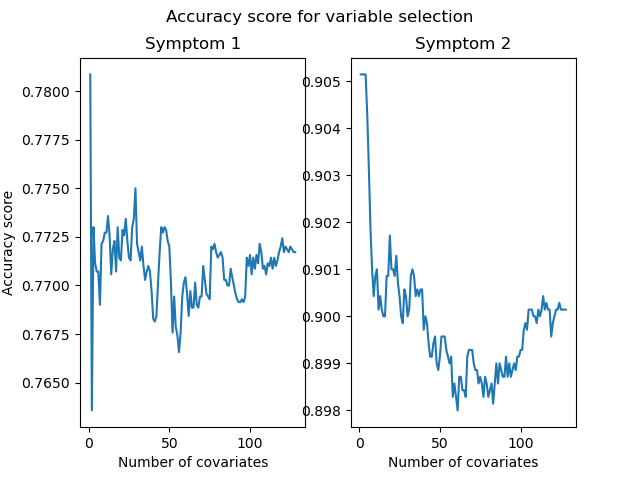

In [3]:
display(Image(filename="img/var_sel.png", width = 600))

##### Hierarchical model

The relationship we are interested in is given by $y_t | a_t$, that is, how is the outcome for the observation dependent on the intervention ($a_t$). Before we can do this, we would like to consider the causes for the symptoms $x_{129}$ and $x_{130}$. This can be considered as a hierachical model in the Bayesian framework. If we look at a model posterior, we have

$$
\phi (\mu_i | \vec{y}) = \frac{P(\vec{y} | \mu_i) \phi (\mu_i)}{\sum_{i} P(\vec{y} | \mu_i) \phi (\mu_i)}
$$

for a model $\mu_i$, adapted from (Dimitrakakis, 2020, p. 98). The problem we then have is to specify a prior for the different models, this could for example be a noninformative prior (e.g. uniform) if we have no specific information to suggest otherwise prior to selecting the models. For simplicity, we define the single-cause models as having one covariate and the multiple-cause model as having all the covariates. In our case, we then have 129 different models for each of the symptoms. If we consider the different models as being different logistic regression using the different covariates we could define the structure

$$
\eta_t(\vec{x}_t) = \beta_0 + \vec{\beta}^{T}\vec{x}
$$

further, this would give the conditional probability

$$
Pr(ys_t = 1 | x = x_t) = \frac{e^{\eta_t(\vec{x}_t)}}{1 + e^{\eta_t(\vec{x}_t)}}
$$

adapted from (Hastie et al., 2016, p. 119). Where $ys_t$ is the symptom response for observation $t$. After calculating the model, we would then have $P(\vec{y} | \mu_i)$, the likelihood of the observed data given the model $\mu_i$. Obviously, we do not know $\phi(\mu_i)$, so we use a subjective probability distribution $\xi$ (Dimitrakakis, 2020, p. 108) as an estimator of the true (unknown) $\phi$.

The symptom response $ys_t$ is then Bernoulli distributed with parameter $\eta_t(\vec{x}_t)$. If we call

$$
Pr(ys_t = 1 | x = x_t) = p_t
$$

the likelihood can then be written

$$
l(\vec{\beta}) = \prod_{i=1}^{n} p_t^{ys_t} \cdot (1-p_t)^{1-ys_t} 
$$

which has log-likelihood

$$
loglik(\vec{\beta}) = \sum_{i=1}^{n} ys_t log(p_t) + (1-ys_t) log(1 - p_t)
$$

adapted from (Hastie et al., 2016, p. 120). This will provide us with the opportunity of calculating the likelihood of the data given the different models which then again will allow us to calculate the posterior probability of the different models. 


Plotting the posterior probabilities for symptom 1

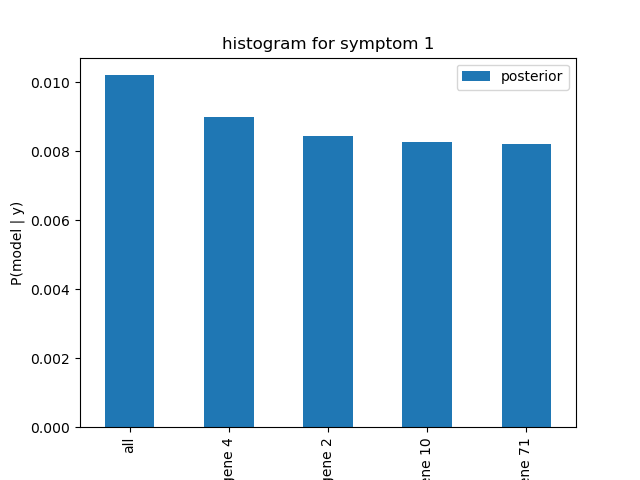

In [4]:
display(Image(filename="img/histogram_for_symptom_1.png", width = 600))

Plotting the posterior probabilities for symptom 2

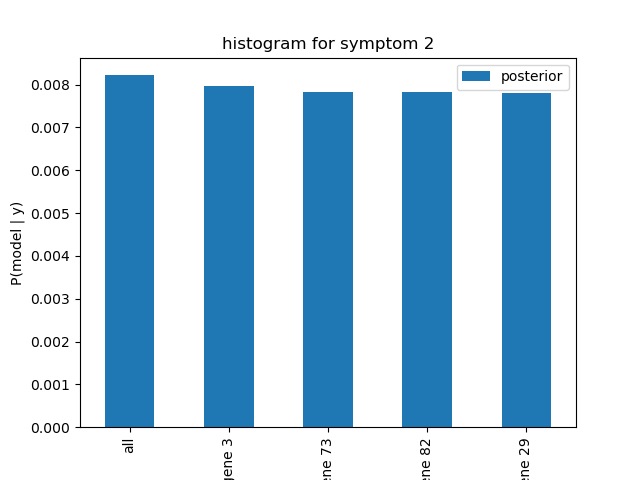

In [5]:
display(Image(filename="img/histogram_for_symptom_2.png", width = 600))

From the plots of the posterior probability for the model, we see that the full model has the highest posterior probability of the different models. This is likely related to the fact that the likelihood of the data is calculated using the model that was also fitted with this data. We see that the single covariates 'gene 4' and 'gene 3' are the models with the highest posterior probability for symptom 1 and symptom 2 respectively. This seems to support the accuracy score from the part above.


##### Experimental hybrid hierarchical

We also use cross-validation in order to reduce the overfitting, this turns into a hybrid version which is using training data to fit a model and then calculates the likelihood of test data by using this model. The results are shown below.

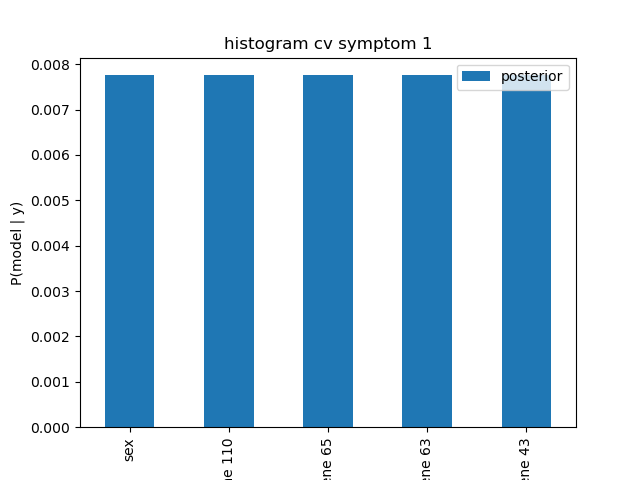

In [6]:
display(Image(filename="img/histogram_cv_symptom_1.png", width = 600))

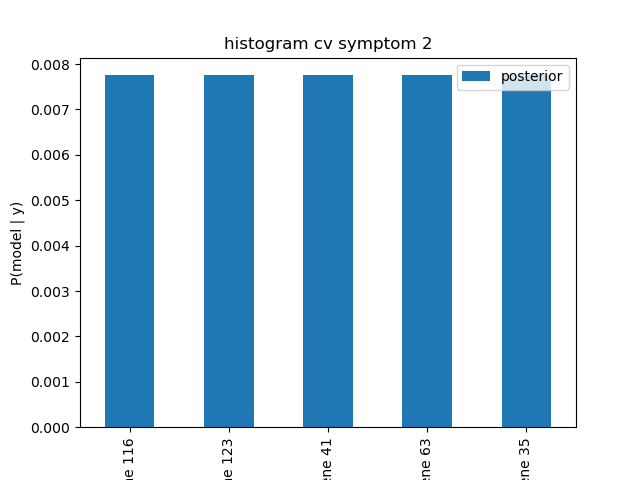

In [7]:
display(Image(filename="img/histogram_cv_symptom_2.png", width = 600))

#### Factors that may be important for disease epidemiology

Based on the variable selection using stratified cross-validation and logistic regression above it could be important to look further into the gene expression that were selected using the variable selection above for the different symptoms. Since the predictive ability of the model seems to be best (on the validation set within the cross-validation) it implies that these genes should be further investigated. This could point toward there being a single-cause model and intuitively, if the data of the selected genes could be measured more accurately/effectively, this could be important for disease epidemiology.

In an ideal world, we would know if we found a sufficient covariate for the outcome $y_t$. This would imply that the outcome would be conditionally independent of the policy given this covariate and the action $a_t$ (Dimitrakakis, 2020, pp. 137-138). Intuitively, if we knew that for example 'gene 3' was the sufficient covariate, we would need only to check this covariate for the different observations. 

More likely is maybe the case where one of the covariates found above is an instrumental variable? In this case, the instrumental variable is a "representation" of the underlying/latent variable that affects both the outcome $y_t$ and the action $a_t$ (Dimitrakakis, 2020, p. 138). If this instrumental variable is possible to measure it could still function as a proxy for the sufficient variable (which may be unobservable).

### Measuring the effect of actions

We now need to look into the action $a$ and the outcome $y$ followed by this action. Intuitively, what we would like to measure is $y_t | a_t$, that is, the outcome given the different actions (in this case therapeutic intervention). If we define $y_t = 1$ to be a positive outcome (positive outcome) and $y_t = 0$ a negative outcome (no effect of action). Then we could define $a_t = 0$ to be placebo (no intervention) and $a_t = 1$ to be the intervention/medication.

When looking at the outcome variable $y_t$ we could think of this as a Bernoulli distributed variable when $a_t$ is given. We could then look at the estimator for the utility of a policy given an action $a_t$. We then have

$$
\hat{E} (U|a_t = a) = \frac{\sum_{t \in a_t = a} U(a_t, y_t)}{|a_t = a|}
$$

adapted from (Dimitrakakis, 2020, pp. 140-141). For simplicity, we assume that we have an utility function $U(a_t = 1, y_t = 1) = 1$ which is, the observation were given a treatment ($a_t = 1$) and it did have a postive effect ($y_t = 1$). On the other hand $U(a_t = 1, y_t = 0) = 0$, the utility for treated observations which still has symptoms.

Similarily for those observations that got placebo treatment $a_t = 0$. This gives the following

$$
\begin{aligned}
U(a_t = 1, y_t = 1) = 1 \\
U(a_t = 1, y_t = 0) = 0 \\
U(a_t = 0, y_t = 1) = 1 \\
U(a_t = 0, y_t = 0) = 0
\end{aligned}
$$

This approach will simply look at the action $a$ and the outcome $y$ from the action. So this measurement will only check $y_t | a_t$ independent of the historical data $x_t$. So in a sense it is only measuring the action $a_t$ independently of the previous condition (symptoms) in $x_t$.

I then implemented the method

In [8]:
def measure_effect(self, action):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        return self._utility(a_array, y_array, action)

with the (private) helper method

In [9]:
def _utility(self, a, y, at):
        """Calculates utility.

        Args:
            a: action array
            y: outcome array
            at: action to measure utility for

        Returns:
            Utility for observation.
        """
        num_at = len(np.where(a == at)[0])
        u = 0

        for i in range(len(a)):
            if a[i] == at and y[i] == 1:
                u += 1

        return u/num_at

running this on the entire dataset gave expected utility from the treatment $a_t = 1$ to be $\approx 66$ times larger than the expected utility from the placebo $a_t = 0$.

From the fact that the expected utility for active treatment is higher than the expected utility from the placebo, it could indicate that the active treatment should be recommended. We try to separate the 'symptom 1' cases from the 'symptom 2' cases. We then want to examine the expected utility of active treatment ($a_t = 1$) versus placebo ($a_t = 0$) and condition on the symptom. Trying to find this out, we implemented the following method

In [10]:
def measure_effect_symptom(self, action, symptom):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo
            symptom: separate observations based on symptom

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        x_joined = [self.x_train, self.x_test]
        x = pd.concat(x_joined)

        if symptom == 1:
            sym_idx = x.iloc[:, -2] == 1
        else:
            sym_idx = x.iloc[:, -1] == 1

        a_cond_sym = a_array[sym_idx]
        y_cond_sym = y_array[sym_idx]

        return self._utility(a_cond_sym, y_cond_sym, action)

and got the following results (for the entire dataset):

E(U|a_t = 0, sym = 1) = 0.01427469135802469

E(U|a_t = 1, sym = 1) = 0.5964479526393686

E(U|a_t = 0, sym = 2) = 0.008955223880597015

E(U|a_t = 1, sym = 2) = 0.5956112852664577

this could maybe indicate that the active treatment has an effect in all the observed cases because the expected utility is relatively higher for the active treatment than placebo?

## Improved policies

### Exercise 1

In this exercise we will use the assumptions and the utility function from the exercise text

$$
a_t \in \{0, 1\}
$$

where 0 is placebo and 1 is treatment and

$$
y_t \in \{0, 1\}
$$

where 0 is no effect and 1 is effect (assumed positive). The utility function as defined

$$
U(a_t, y_t) = -0.1a_t + y_t
$$

The current policy ($\pi_0$) which the medical data comes from is unknown. What we know about the policy $\pi_0$ however, is that it assigns either $a_t = 0$ or $a_t = 1$.

To say anything about the utility of a policy, we must define what the expected utility is. We can use the following

$$
E^{\pi}_{\theta}[U] = \int \sum_{a} \pi(a | x) \sum_{y} P_{\theta} (y | x, a) U(a, y) dP_{\theta} (x)
$$

adapted from (Dimitrakakis, 2020, p. 141). Further, it is possible to estimate this integral by using a form of Monte-Carlo estimation 

$$
E^{\pi}_{\theta}[U] \approx \frac{1}{n} \sum_{i=1}^{n} \sum_{a} \pi (a|x_t) \sum_{y} P_{\theta} (y | a, x_t) U(a, y)
$$

adapted from (Dimitrakakis, 2020, pp. 141-142). The approximation above can then be used in order to estimate the expected utility.

#### Measuring the utility of the historical policy on the historical data

##### Approach 1: direct calculation

Provided that we now have the actions, $a_t$, for the different observations $t$ and we have a function for calculating utility based on $a_t$ and $y_t$ it would be possible to calculate the utility directly. In this case we know there is a historical policy $\pi_0$ which was used in order to create the actions. This could be represented as 

$$
\pi_0 (a_t | x_t)
$$

the exact policy $\pi_0$ is still unknown to us, but we have observed the provided $a_t$ values, so how the decisions were taken by the policy would not necessarily affect our utility calculation. This implies that we could calculate the total utility as 

$$
U = \sum_{t=1}^{T} U(a_t, y_t)
$$

and the average utility as

$$
u = \frac{1}{T}\sum_{t=1}^{T} U(a_t, y_t)
$$

for this specific case

$$
u = \frac{1}{T}\sum_{t=1}^{T} U(a_t, y_t) \approx 0.1191
$$

this gave an average utility of 0.1191 over all the historical data.

##### Approach 2: expected utility

If we attempt to estimate the expected utility integral above, we could get a more detailed overview of the utility of the policy $\pi_0$. 

###### Simplification: model 0
As a simplification, we assume that the action $a_t$ is independent of the personal information of the individual observations, $x_t$. The outcome ($y_t$) however, we assume depends on the action $a_t$. We could then express this situation as 

$$
\begin{aligned}
a_t \sim Bernoulli(\pi_0) \\
y_t | a_t \sim Bernoulli(\theta_a)
\end{aligned}
$$

adapted from (Dimitrakakis, 2020, p. 146). In this situation, the action $a_t$ is Bernoulli distributed with parameter $\pi_0$ correspondning to our historical policy. Further, the outcome (whether or not the observation had measurable effect) will depend on the action $a_t$, again as a Bernoulli distributed random variable. Intuitively, we would expect that when active treatment is provided ($a_t=1$), the probability of effect ($y_t=1$) is higher. Typically, we would then expect that $\theta_1$ should be weighted in favor of $y_t = 1$.

A possible estimator for the parameter $\pi_0$ is the fraction of $a_t = 1$ in the historical data. This would then imply that $\hat{\pi}_0 = \frac{\sum_{t}^{n} I(a_t = 1)}{n}$, which could be estimated from the data.

In order to estimate the Bernoulli parameter $\theta_a$, we can used the maximum likelihood estimator for the variable 

$$
\hat{\theta}_a = \frac{\sum_{t} y_t \cdot I(a_t = a)}{\sum_{t} I(a_t = a)}
$$

adapted from (Dimitrakakis, 2020, p. 143). Once we have estimated $\theta_a$, we could sample from $Bernoulli(\pi_0)$ in order to get the $a_t$, then we could use $\theta_a$ in order to sample from $y_t | a_t$. In this case, $\theta_a | a_t$ is a conditional variable.

The posterior distribution for $a_t$ would then be

$$
p(a_t | y_t) \propto p(a_t) p(y_t | a_t)
$$

and from this posterior distribution, we can sample pairs of ($a_t, y_t$) created with the approximate policy $\hat{\pi}_0$. We calculate the expected utility after sampling from the 'model 0' above with $\pi_0$ and $\theta_a$ from the historical policy.


Assuming model 0 it is also possible to calculate the expected value of the utility analytically. For doing this we will be using the fact that

$$
E[Y] = E[E[Y|A]] = \sum_{a_t} E[Y|A=a_t] \cdot P(a_t)
$$

adapted from (Devore & Berk, 2012, p. 261). This allows us to calculate the expected utility of a single observation analytically. Using the provided function from the exercise text we get

$$
\begin{aligned}
E[U] = E[\sum_{t} r_t] = \sum_{t} E[r_t] \\
= \sum_{t} E[-0.1 a_t + y_t] \\
= \sum_{t} -0.1E[a_t] + E[y_t] \\
\end{aligned}
$$

in this model, $y_t$ is dependent on $a_t$, we then have to use the expected value of $y_t$ conditioned on $a_t$. This gives

$$
E[y_t] = E[E[y_t | a_t]] = \sum_{a_t} E[y_t | a = a_t] P(a_t)
$$

proceding and looking at a single observation we get 

$$
E[U_t] = -0.1E[a_t] + \sum_{a_t} E[y_t | a = a_t] P(a_t)
$$

further, we know that a Bernoulli distributed variabel $x$ has $E[X] = p(X = 1)$ (Devore & Berk, 2012, p. 113). Utilizing this together with the estimates $\hat{\pi}_0$ and $\hat{\theta}_a$ that (estimated from historical data) is

$$
\begin{aligned}
\hat{\pi}_0 = 0.2298 \\
\hat{\theta}_a = (\theta_0, \theta_1) \approx (0.008959, 0.588338)
\end{aligned}
$$

which means that

$$
\begin{aligned}
E[U_t] = -0.1E[a_t] + (E[y_t | a = 0]P(a = 0) + E[y_t | a = 1]P(a = 1)) \\
E[U_t] = -0.1 \cdot 0.2298 + (0.008959 \cdot 0.7702 + 0.588338 \cdot 0.2298) \\
\hat{E}(U_t) \approx 0.119120
\end{aligned}
$$

given that $\hat{\pi}_0$ and $\hat{\theta}_a$ is estimated from the historical data, it is intuitively reasonable that the expected utility based on this approach is similar to the historical average utility.

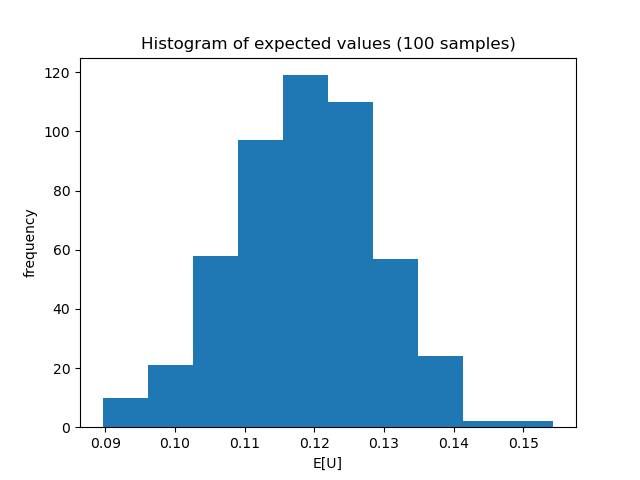

In [12]:
display(Image(filename="img/part2_1_method0_hist.png", width = 600))

###### Simplification: bootstrap approach

Another approach for estimating error bounds for the expected utility is nonparametric bootstrap. We already have a large sample, so the central limit theorem is already affecting the calculation of the expected utility. 

In general, we would sample with replacement from the relevant pairs of data. The samples would be the same size as the original dataset. Then we use each of the sampled dataset to calculate $\hat{\theta}$ and then we have a "distribution" of $\hat{\theta}$. This "distribution" can then be used to estimate different quantities of interest (Hastie et al., 2016, p. 249). We can use this general idea and define $\hat{\theta}$ as the expected utility. In this way we can estimate a variance for the expected utility. This would intuitively describe error bounds on the expected utility as it describes the fact that the sample of observations is just that, a sample from the true, unknown, population of observations.

The bootstrap expected utilities can be seen in the histogram below


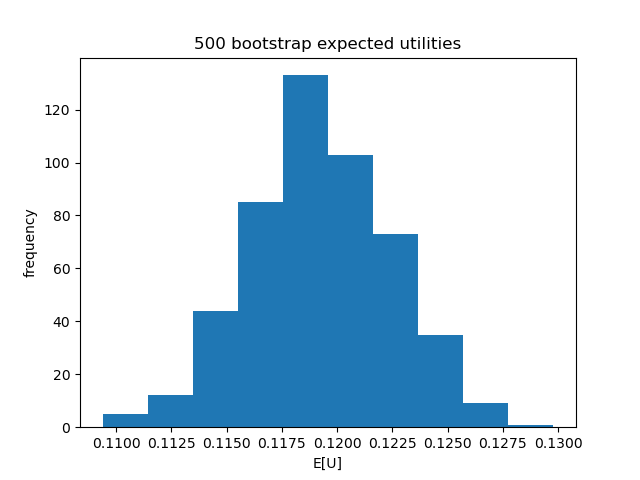

In [13]:
display(Image(filename="img/part2_1_bootstrap_hist.png", width = 600))

Specifically, we see that the histogram of expected utilities is relatively narrow compared to the histogram from the model 0 above.

#### Error bounds for expected utility

##### Methodologies compared

##### 1. Percentile intervals

We could base our approximation of the error bounds on the percentile interval, commonly used within bootstrap methods. This would involve calculating the approximated expected utility, which is a mean of the expected values, then we would selct the $i_B = \frac{\alpha (n_B + 1)}{2}$ from the two ends of the sorted array of estimates in order to get the $100(1-\alpha)\%$ percentile interval (Devore & Berk, 2012, p. 414). For the expected utility, this would involve calculating $n_B$ expected utilities and then looking at the percentile interval at for example $95\%$.

##### 2. Bootstrap confidence intervals

Looking at the histogram above, it could resemble an approximation to a normal distribution. The central limit affect the distribution of the means when $n \rightarrow \infty$ and ensures approximate normality in the distribution of the means (Devore & Berk, 2012, p. 298). This we can utilize further when attempting to estimate error bounds. The CLT allows us to use critical values from the normal distribution quantiles together with an approximation to the variance of the mean in order to estimate the confidence interval. This approximation to the variance of the mean is given as

$$
\hat{\sigma}^2 = \frac{1}{n_B - 1} \sum_{i = 1}^{n_B} (\bar{x}^{*}_i - \bar{x}^{*})^{2}
$$

adapted from (Devore & Berk, 2012, p. 413). This, together with the critical value for the quantile allows us to create an error bound for the expected utility.

##### 3. Estimating analytical variance when using simplification model

In simplification cases where the data is assumed to follow a certain distribution this enables us to calculate the empirical variance based on the simplified model. This method for estimating error bounds depends on the model that is assumed to represent the data.

##### Model 0

##### method: percentile interval

The error bounds below is adapted from Dirk's code from lecture 10 (Github, 2020). From it we se the expected utility as circles while the error bounds are based on the 2.5 and 97.5 percentile. The sampling is repeated as many times as there are error bounds shown below. The expected (mean) utility seems to be close to the historical utility.

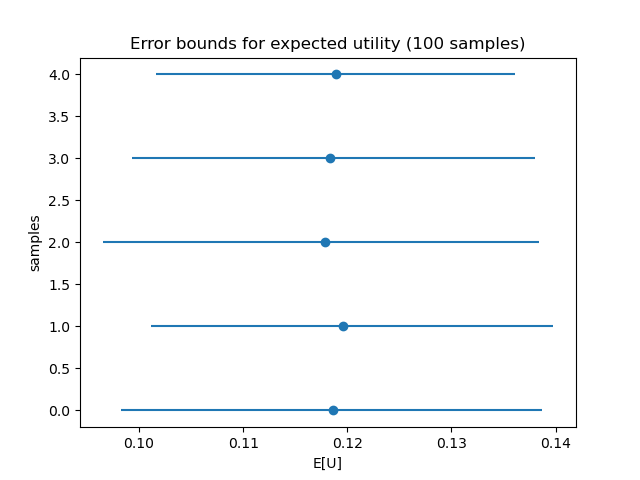

In [8]:
display(Image(filename="img/part2_1_method0_error.png", width = 600))

This plot shows the expected value as the circles and the different samples along the y-axis. We also see from the previous point that the historical utility calculated from the original historical data is included in the different percentile intervals based on the sampled data from the posterior distribution of $a_t$.

##### method: bootstrap confidence interval

Testing the bootstrap confidence interval approach gave the following when using the critical value $z_{0.025} = 1.96$ for a 95 % bootstrap confidence interval.


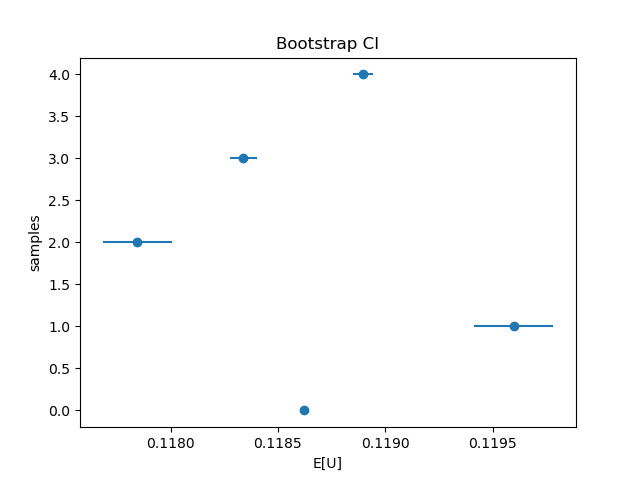

In [18]:
display(Image(filename="img/part2_1_method0_bootci.png", width = 600))

From the bootstrap confidence interval, we see that the expected utiity also with this case is relatively close to the historical expected value $\approx 0.1191$

##### method: analytical variance

We can calculate the empirical variance of the utility based on the simplified model. Given that we assume $a_t$ and $y_t$ as Bernoulli variables, we can calculate the variance of the utility function (equal to reward $r_t$ for a single observation). We have from the section above that 

$$
E[r_t] \approx 0.119120
$$

and we can now estimate $V[r_t]$, given model 0. This implies we can create an approximated confidence interval 

$$
E[r_t] \pm z_{\frac{\alpha}{2}} \frac{s}{\sqrt{n}}
$$

adapted from (Devore & Berk, 2012, p. 392). We then want to estimate $V[r_t]$, we want to use the fact that $y_t | a_t$ and we then get

$$
V[r_t] = V[-0.1 a_t + y_t] = (-0.1)^2 V[a_t] + V[y_t]
$$

Because the variance of a Bernoulli distributed variable $X$ is $V[X] = P(X=1) \cdot (1 - P(X=1))$, adapted from (Devore & Berk, 2012, p. 308) we have that

$$
V[a_t] = P(a_t = 1) \cdot (1 - P(a_t = 1)) \\
= \hat{\pi}_0 \cdot (1 - \hat{\pi}_0)
$$

which we have estimated values for in the section about expected values.

In order to estimate the variance of $y_t$, we use the following relation 

$$
V[y_t] = V[E[y_t|a_t]] + E[V[y_t|a_t]]
$$

adapted from (Devore & Berk, 2012, p. 261) in order to calculate the variance of $y_t$. We can the calculate the two terms, starting with the expected value of the conditional variance

$$
\begin{aligned}
E[V[y_t|a_t]] = V[y_t|a_t = 0]P(a_t = 0) + V[y_t|a_t = 1]P(a_t = 1) \\
= P(y_t = 1 |a_t = 0) \cdot (1 - P(y_t = 1 |a_t = 0)) \cdot P(a_t = 0) + P(y_t = 1 |a_t = 1) \cdot (1 - P(y_t = 1 |a_t = 1)) \cdot P(a_t = 1) \\
= \hat{\theta}_0 \cdot (1 - \hat{\theta}_0) \cdot (1 - \hat{\pi}_0) + \hat{\theta}_1 \cdot (1 - \hat{\theta}_1) \cdot \hat{\pi}_0 \\
= 0.0090 \cdot (1 - 0.0090) \cdot (1 - 0.2298) + 0.5883 \cdot (1 - 0.5883) \cdot 0.2298 \\
\approx 0.0625
\end{aligned}
$$

then we can calculate the variance of the conditional expected value, calling $E[y_t|a_t] = X$ and $E[E[y_t|a_t]] = \mu$ and use the equation for variance expressed as an expectation value (Devore & Berk, 2012, p. 173), this then gives

$$
\begin{aligned}
V[E[y_t|a_t]] = V[X] = E[(X - \mu)^2] \\
= (E[y_t|a_t = 0] - \mu)^2 P(a_t = 0) + (E[y_t|a_t = 1] - \mu)^2 P(a_t = 1) \\
= (0.0090 - 0.1421)^2 \cdot (1 - \hat{\pi}_0) + (0.5883 - 0.1421)^2 \cdot \hat{\pi}_0 \\
\approx 0.0594
\end{aligned}
$$

we then have from the section above that 

$$
\begin{aligned}
E[E[y_t|a_t]] \approx 0.1421 \\
E[y_t|a_t = 0] \approx 0.0090 \\
E[y_t|a_t = 1] \approx 0.5883
\end{aligned}
$$

now we can substitute this into the first relation

$$
V[y_t] = 0.0594 + 0.0625 \approx 0.1219
$$

and then we can estimate the variance for the reward $r_t$

$$
\begin{aligned}
V[r_t] = V[-0.1 a_t + y_t] = (-0.1)^2 V[a_t] + V[y_t] \\
= (-0.1)^2 \cdot 0.2298 \cdot (1 - 0.2298) + 0.1219 \\
\approx 0.1237
\end{aligned}
$$

now we are able to estimate an approximate 95 % confidence interval

$$
\begin{aligned}
E[r_t] \pm z_{\frac{\alpha}{2}} \frac{s}{\sqrt{n}} \\
0.1191 \pm 1.96 \frac{\sqrt{0.1237}}{\sqrt{10000}} \\
[0.1122, 0.1260]
\end{aligned}
$$


Just from visual comparison, this confidence interval seems to correspond fairly well with the bootstrap confidence interval and the histogram of expected utilities in the section above.

##### Bootstrap approach

###### method: percentile interval

We can now use the percentile method in order to select percentile of the expected utilities from bootstrap samples. From the plot below, we see that the boostrap percentile intervals for a 95 % confidence interval are extremely similar across the repetitions.

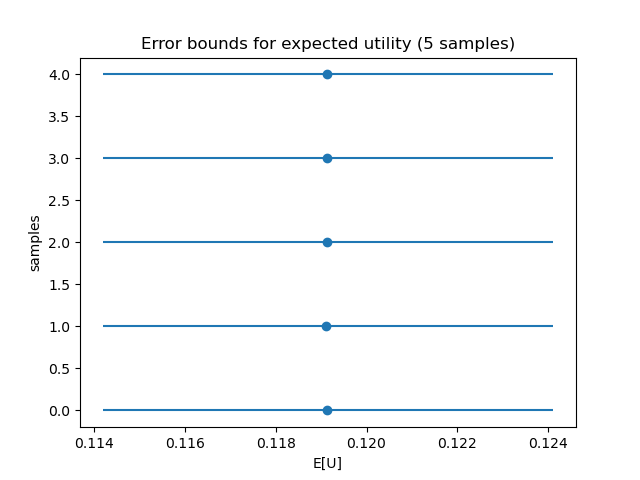

In [17]:
display(Image(filename="img/part2_1_bootstrap_percentile_ci.png", width = 600))

##### method: bootstrap confidence interval

We can also try with the bootstrap confidence interval as described above in order to establish error bounds on the expected utility. The bootstrap confidence intervals plotted below are also very similar across the repetitions. This is very noticable when comparing to the bootstrap confidence interval when model 0 is assumed to be correct.

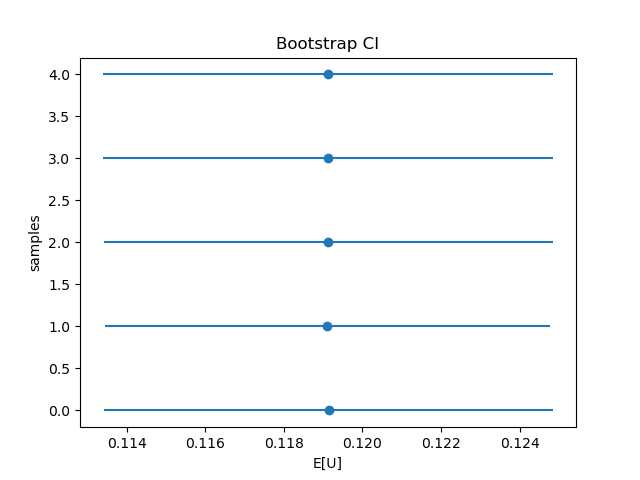

In [22]:
display(Image(filename="img/part2_1_bootstrap_bootstrap_ci.png", width = 600))

# References

Borgan, Ø. (2019). Regresjon og konfundering - notat til STK1110. Retrieved from: https://www.uio.no/studier/emner/matnat/math/STK1110/h19/confounding-regresjon.pdf

Dawid, A. P. (2015). Statistical Causality from a Decision-Theoretic Perspective. Annual Review of Statistics and Its Application, 2(1), 273-303.

Dimitrakakis, C. (2020). Machine learning in science and society. Unpublished. Department of Informatics, University of Oslo.

Devore, J. & Berk, L. (2012). Modern Mathematical Statistics with Applications
(Springer Texts in Statistics). New York, NY: Springer New York.

Github. (2020, n.d.). Lecture 10 - Multilevel Models. Retrieved from https://github.com/dhesse/IN-STK5000-Notebooks-2020/blob/master/notebooks/Lecture%2010%20-%20Multilevel%20Models.ipynb 

Hastie, T., Tibshirani, R. & Friedman, J. (2016). The Elements of Statistical Learning. Data Mining,
Inference and Prediciton. New York, NY: Springer New York.

James, G., Witten, D., Hastie, T. & Tibshirani, R. (2013). An Introduction to Statistical Learning (Vol. 103
Springer Texts in Statistics). New York, NY: Springer New York.

scikit learn. (2020, n.d.). sklearn.feature_selection.RFECV. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

# Appendices

## Part 1

E[U|a_t = 1] = 0.5883376849434291
E[U|a_t = 0] = 0.008958712022851208
E[U|a_t = 1, sym = 1] = 0.5964479526393686
E[U|a_t = 1, sym = 2] = 0.5956112852664577
E[U|a_t = 0, sym = 1] = 0.01427469135802469
E[U|a_t = 0, sym = 2] = 0.008955223880597015


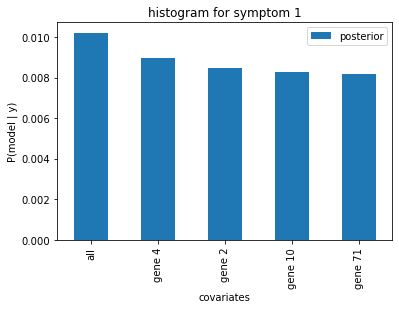

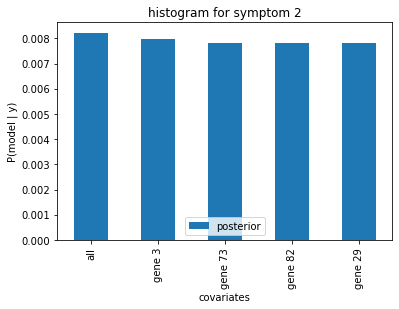

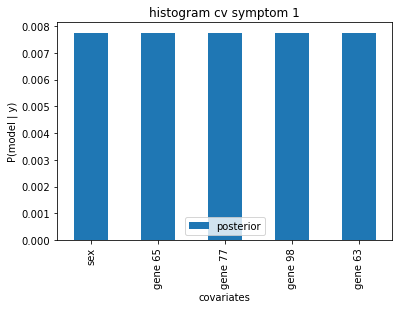

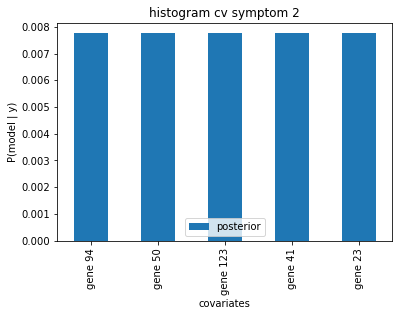

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss


class MedicalData:
    def __init__(self):
        self._get_data()

    def _get_data(self):
        """Gets the data and places it into three dataframes stored as instance
        variables of the object.
        """
        x = pd.read_csv("./data/medical/historical_X.dat",
                        sep=" ", header=None)
        personal_columns = ["sex", "smoker"]
        gene_columns = ["gene " + str(i) for i in range(1, 127)]
        symptom_columns = ["symptom 1", "symptom 2"]
        x_columns = personal_columns + gene_columns + symptom_columns
        x.columns = x_columns

        y = pd.read_csv("./data/medical/historical_Y.dat",
                        sep=" ", header=None)
        y.columns = ["outcome"]

        a = pd.read_csv("./data/medical/historical_A.dat",
                        sep=" ", header=None)
        a.columns = ["action"]

        self.x_train, self.x_test, self.y_train, self.y_test, self.a_train, self.a_test = train_test_split(
            x, y, a, test_size=0.3, random_state=1)

    def data_analysis(self):
        """

        """
        self.frequency_symptoms()
        self.variable_selection(3)

    def _plot_variable_selection(self, accuracy_score1, accuracy_score2, show=False):
        """Plots the accuracy score for the different symptoms.

        Args:
            accuracy_score1: the accuracy score from the CV of symptom 1
            accuracy_score2: the accuracy score from the CV of symptom 2
            show: whether or not to show the plot
        """
        fig, (axis1, axis2) = plt.subplots(1, 2)
        fig.suptitle("Accuracy score for variable selection")

        axis1.plot(range(1, len(accuracy_score1) + 1), accuracy_score1)
        axis1.set_title("Symptom 1")
        axis1.set_ylabel("Accuracy score")
        axis1.set_xlabel("Number of covariates")
        axis2.plot(range(1, len(accuracy_score2) + 1), accuracy_score2)
        axis2.set_title("Symptom 2")
        axis2.set_xlabel("Number of covariates")

        if show:
            plt.show()
        else:
            plt.savefig("img/var_sel.png")

    def variable_selection(self, num_folds):
        """Performs variable selection using a num_folds cross-validation.

        RFECV adapted from https://scikit-learn.org/stable/auto_examples/
        feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-
        examples-feature-selection-plot-rfe-with-cross-validation-py

        Args:
            num_folds: the number of folds to use in the cross-validation
        """
        logistic_regression = LogisticRegression(max_iter=1000)
        variable_selection_cv = RFECV(
            estimator=logistic_regression, step=1, cv=StratifiedKFold(num_folds, random_state=1), scoring='accuracy')

        x = self.x_train.iloc[:, : -2]
        symptom1 = self.x_train.iloc[:, -2]
        symptom2 = self.x_train.iloc[:, -1]

        # symptom 1
        variable_selection_cv.fit(x, symptom1)
        accuracy_symptom1 = variable_selection_cv.grid_scores_
        symptom1_indices = np.where(
            variable_selection_cv.support_ == True)[0]
        print(f"Symptom 1 covariates = {x.columns[symptom1_indices]}")

        # symptom 2
        variable_selection_cv.fit(x, symptom2)
        accuracy_symptom2 = variable_selection_cv.grid_scores_
        symptom2_indices = np.where(
            variable_selection_cv.support_ == True)[0]
        print(f"Symptom 2 covariates = {x.columns[symptom2_indices]}")

        self._plot_variable_selection(accuracy_symptom1, accuracy_symptom2)

    def frequency_symptoms(self, show=False):
        """Generates simple histogram showing the frequency of the different 
        symptoms. Looks at the entire dataset when considering the frequency.

        Args:
            show: whether or not to show the plot
        """
        x_joined = [self.x_train, self.x_test]
        x = pd.concat(x_joined)

        fig, (axis1, axis2) = plt.subplots(1, 2)
        fig.suptitle("Histogram of symptoms")
        axis1.hist(x["symptom 1"], color='b')
        axis1.set_title("Symptom 1")
        axis2.hist(x["symptom 2"], color='r')
        axis2.set_title("Symptom 2")

        if show:
            plt.show()
        else:
            plt.savefig("img/freq_hist.png")

    def measure_effect(self, action):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        return self._utility(a_array, y_array, action)

    def measure_effect_symptom(self, action, symptom):
        """Calculates the measured effect of an action.

        Args:
            action: 1 for treatment and 0 for placebo
            symptom: separate observations based on symptom

        Returns:
            The measured effect.
        """
        y_joined = [self.y_train, self.y_test]
        y = pd.concat(y_joined)
        y_array = self._to_flat_array(y)

        a_joined = [self.a_train, self.a_test]
        a = pd.concat(a_joined)
        a_array = self._to_flat_array(a)

        x_joined = [self.x_train, self.x_test]
        x = pd.concat(x_joined)

        if symptom == 1:
            sym_idx = x.iloc[:, -2] == 1
        else:
            sym_idx = x.iloc[:, -1] == 1

        a_cond_sym = a_array[sym_idx]
        y_cond_sym = y_array[sym_idx]

        return self._utility(a_cond_sym, y_cond_sym, action)

    def _to_flat_array(self, df):

        numpy_array = df.to_numpy()
        return numpy_array.flatten()

    def _utility(self, a, y, at):
        """Calculates utility.

        Args:
            a: action array
            y: outcome array
            at: action to measure utility for

        Returns:
            Utility for observation.
        """
        num_at = len(np.where(a == at)[0])
        u = 0

        for i in range(len(a)):
            if a[i] == at and y[i] == 1:
                u += 1

        return u/num_at

    def hierarchical_model(self, data, symptom):
        """Calculates the hierarchical model for the medical data.

        Args:
            data: the data to calculate the posterior probability
            symptom: which symptom to use as response variable

        Returns:
            Posterior probabilites in a Pandas dataframe.
        """
        x = data.iloc[:, : -2]
        if symptom == 1:
            symptom = data.iloc[:, -2]
        else:
            symptom = data.iloc[:, -1]

        num_models = len(x.iloc[0])
        log_likelihoods = np.zeros(num_models + 1)
        model = LogisticRegression(max_iter=500)

        for i in range(0, num_models + 1):
            if i != num_models:
                single_column = x.iloc[:, i].to_numpy()
                single_covariate = single_column.reshape(-1, 1)
                log_reg = model.fit(single_covariate, symptom)
                p_t = log_reg.predict_proba(single_covariate)
                log_likelihoods[i] = -log_loss(symptom, p_t)
            else:
                log_reg = model.fit(x, symptom)
                p_t = log_reg.predict_proba(x)
                log_likelihoods[i] = -log_loss(symptom, p_t)

        # calculating the posterior
        likelihood = np.exp(log_likelihoods)
        prior = np.repeat(1/(num_models + 1), num_models + 1)
        p_y = np.sum(likelihood*prior)
        posterior = (likelihood*prior)/p_y

        # constructing the dataframe
        last_index = pd.Index(data=["all"])
        model_names = x.columns.append(last_index)
        posterior_df = pd.DataFrame(data=posterior, index=model_names)
        posterior_df.columns = ["posterior"]

        return posterior_df

    def _calculate_posterior(self, xtrain, xtest, ytrain, ytest):
        """Calculates the posterior of a test set using a model fitted on 
        training data.

        Args:
            xtrain: training covariates
            xtest: test covariates
            ytrain: training response
            ytest: test response

        Returns:
            The posterior probability of the different models.
        """
        num_models = len(xtrain.iloc[0])
        log_likelihoods = np.zeros(num_models + 1)

        model = LogisticRegression(max_iter=500)

        for i in range(0, num_models + 1):
            if i != num_models:
                single_column = xtrain.iloc[:, i].to_numpy()
                single_covariate = single_column.reshape(-1, 1)
                log_reg = model.fit(single_covariate, ytrain)

                single_column_test = xtest.iloc[:, i].to_numpy()
                single_covariate_test = single_column_test.reshape(-1, 1)
                p_t = log_reg.predict_proba(single_covariate_test)

                log_likelihoods[i] = -log_loss(ytest, p_t)
            else:
                log_reg = model.fit(xtrain, ytrain)

                p_t = log_reg.predict_proba(xtest)
                log_likelihoods[i] = -log_loss(ytest, p_t)

        likelihood = np.exp(log_likelihoods)
        prior = np.repeat(1/(num_models + 1), num_models + 1)
        p_y = np.sum(likelihood*prior)
        posterior = (likelihood*prior)/p_y

        return posterior

    def hierarchical_model_cv(self, symptom, k):
        """Calculates the hierarchical model for the medical data.

        Args:
            symptom: which symptom to use as response variable
            k: the number of folds to use in the cross-validation

        Returns:
            Posterior probabilites in a Pandas dataframe.
        """

        num_models = len(self.x_train.iloc[0]) - 1
        # (folds, models)
        cv_posterior = np.zeros((k, num_models))

        x_joined = [self.x_train, self.x_test]
        x_raw = pd.concat(x_joined)
        x = x_raw.iloc[:, : -2]

        if symptom == 1:
            y = x.iloc[:, -2]
        else:
            y = x.iloc[:, -1]

        kf = KFold(n_splits=k, shuffle=True)
        k_counter = 0

        for train_indices, test_indices in kf.split(x):
            xtrain = x.iloc[train_indices, :]
            ytrain = y[train_indices]
            xtest = x.iloc[test_indices, :]
            ytest = y[test_indices]

            posterior = self._calculate_posterior(xtrain, xtest, ytrain, ytest)
            cv_posterior[k_counter, :] = posterior
            k_counter += 1

        posterior = np.mean(cv_posterior, 0)

        # constructing the dataframe
        last_index = pd.Index(data=["all"])
        model_names = x.columns.append(last_index)
        posterior_df = pd.DataFrame(data=posterior, index=model_names)
        posterior_df.columns = ["posterior"]

        return posterior_df


def plot_posteriors(posteriors, num, title, show=True):
    """Plots the top k posterios.

    Args:
        posteriors: sorted Pandas dataframe with posteriors
        num: the number of posteriors to plot
        title: title of the histogram
        show: whether or not to show the plot
    """
    plot_posteriors = posteriors.sort_values(
        by="posterior", ascending=False)[:num]

    plot_posteriors.plot.bar()
    plt.title(title)
    plt.xlabel("covariates")
    plt.ylabel("P(model | y)")

    if show:
        plt.show()
    else:
        filename = title.replace(" ", "_") + ".png"
        plt.savefig("img/" + filename)


if __name__ == "__main__":
    data = MedicalData()
    # data.data_analysis()
    expected_utility_1 = data.measure_effect(1)
    expected_utility_0 = data.measure_effect(0)
    print(f"E[U|a_t = 1] = {expected_utility_1}")
    print(f"E[U|a_t = 0] = {expected_utility_0}")

    util_sym1_a1 = data.measure_effect_symptom(1, 1)
    util_sym2_a1 = data.measure_effect_symptom(1, 2)
    util_sym1_a0 = data.measure_effect_symptom(0, 1)
    util_sym2_a0 = data.measure_effect_symptom(0, 2)
    print(f"E[U|a_t = 1, sym = 1] = {util_sym1_a1}")
    print(f"E[U|a_t = 1, sym = 2] = {util_sym2_a1}")
    print(f"E[U|a_t = 0, sym = 1] = {util_sym1_a0}")
    print(f"E[U|a_t = 0, sym = 2] = {util_sym2_a0}")

    x_joined = [data.x_train, data.x_test]
    x = pd.concat(x_joined)
    sym1_posteriors = data.hierarchical_model(x, 1)
    plot_posteriors(sym1_posteriors, 5, "histogram for symptom 1", show=False)

    sym2_posteriors = data.hierarchical_model(x, 2)
    plot_posteriors(sym2_posteriors, 5, "histogram for symptom 2", show=False)

    sym1_cv_posteriors = data.hierarchical_model_cv(1, 5)
    plot_posteriors(sym1_cv_posteriors, 5,
                    "histogram cv symptom 1", show=False)

    sym2_cv_posteriors = data.hierarchical_model_cv(2, 5)
    plot_posteriors(sym2_cv_posteriors, 5,
                    "histogram cv symptom 2", show=False)

